# Initial EDA

In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/openlifescienceai/medmcqa/" + splits["train"])

In [ ]:
df.head()

,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
0,e9ad821a-c438-4965-9f77-760819dfa155,Chronic urethral obstruction due to benign pri...,Hyperplasia,Hyperophy,Atrophy,Dyplasia,2,single,Chronic urethral obstruction because of urinar...,Anatomy,Urinary tract
1,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,Which vitamin is supplied from only animal sou...,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,2,single,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,Biochemistry,Vitamins and Minerals
2,5c38bea6-787a-44a9-b2df-88f4218ab914,All of the following are surgical options for ...,Adjustable gastric banding,Biliopancreatic diversion,Duodenal Switch,Roux en Y Duodenal By pass,3,multi,"Ans. is 'd' i.e., Roux en Y Duodenal Bypass Ba...",Surgery,Surgical Treatment Obesity
3,cdeedb04-fbe9-432c-937c-d53ac24475de,Following endaerectomy on the right common car...,Central aery of the retina,Infraorbital aery,Lacrimal aery,Nasociliary aretry,0,multi,The central aery of the retina is a branch of ...,Ophthalmology,None
4,dc6794a3-b108-47c5-8b1b-3b4931577249,Growth hormone has its effect on growth through?,Directly,IG1-1,Thyroxine,Intranuclear receptors,1,single,"Ans. is 'b' i.e., IGI-1GH has two major functi...",Physiology,None


In [ ]:
y_train_f.value_counts()

,count
subject_name,
Medicine & Pathology,19673
Surgery & Orthopaedics,11863
Anatomy,8772
Pharmacology,8201
Social & Preventive Medicine,7147
Microbiology,6689
Skin & Dental,6397
Gynaecology & Obstetrics,6074
Physiology,5281


In [ ]:
print(le.classes_)

['Anaesthesia' 'Anatomy' 'Biochemistry' 'ENT' 'Forensic Medicine'
 'Gynaecology & Obstetrics' 'Medicine & Pathology' 'Microbiology'
 'Ophthalmology' 'Pediatrics' 'Pharmacology' 'Physiology' 'Psychiatry'
 'Radiology' 'Skin & Dental' 'Social & Preventive Medicine'
 'Surgery & Orthopaedics' 'Unknown']


In [ ]:
import pandas as pd

In [ ]:
print("Train size:", train_df.shape[0])
print("Test size:", test_df.shape[0])
# print("Val size:", val_df.shape[0])

Train size: 91411
Test size: 6150


In [ ]:
# !pip install numpy==1.26.4 --quiet

In [ ]:
# ========== 1. Load MedMCQA splits ============================
import pandas as pd

splits = {
    "train": "data/train-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
}

# Load 50% of train/test for speed
train_df = pd.read_parquet(f"hf://datasets/openlifescienceai/medmcqa/{splits['train']}")
test_df  = pd.read_parquet(f"hf://datasets/openlifescienceai/medmcqa/{splits['test']}")

train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True)
test_df  = test_df.sample(frac=1.0, random_state=42).reset_index(drop=True)


# ========== 2. Combine question and options ===============
def concat_q_with_options(df):
    for col in ["exp"]:
        df[col] = df[col].fillna("").astype(str)

    return df["question"] + " [SEP] " + df["opa"] + " [SEP] " + df["opb"] + \
           " [SEP] " + df["opc"] + " [SEP] " + df["opd"] + df["exp"]

X_train_clean = concat_q_with_options(train_df)
y_train_clean = train_df["subject_name"]

X_test_clean  = concat_q_with_options(test_df)
y_test_clean  = test_df["subject_name"]


# ========== 3. Merge subject categories ===============
merge_map = {
    "Medicine": "Medicine & Pathology",
    "Pathology": "Medicine & Pathology",
    "Orthopaedics": "Surgery & Orthopaedics",
    "Surgery": "Surgery & Orthopaedics",
    "Skin": "Skin & Dental",
    "Dental": "Skin & Dental"
}

y_train_merged = y_train_clean.replace(merge_map)
y_test_merged  = y_test_clean.replace(merge_map)


# ========== 4. Filter top-k classes =====================
top_k = 20
top_subjects = y_train_merged.value_counts().nlargest(top_k).index

mask_train = y_train_merged.isin(top_subjects)
mask_test  = y_test_merged.isin(top_subjects)

X_train_f = X_train_clean[mask_train].reset_index(drop=True)
y_train_f = y_train_merged[mask_train].reset_index(drop=True)

X_test_f  = X_test_clean[mask_test].reset_index(drop=True)
y_test_f  = y_test_merged[mask_test].reset_index(drop=True)


# ========== 5. Train/Val split ===========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_f, y_train_f,
    test_size=0.2,
    stratify=y_train_f,
    random_state=42
)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_final)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test_f)

num_labels = len(le.classes_)


# ========== 6. Tokenization and Dataset ==================
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import AutoTokenizer
from datasets import Dataset

# model_name = "emilyalsentzer/Bio_ClinicalBERT"

model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["text"],
                     truncation=True,
                     padding="max_length",
                     max_length=512)

train_ds = Dataset.from_dict({
    "text": X_train_final.tolist(),
    "label": y_train_enc.tolist()
}).map(tok, batched=True).remove_columns("text").with_format("torch")

val_ds = Dataset.from_dict({
    "text": X_val.tolist(),
    "label": y_val_enc.tolist()
}).map(tok, batched=True).remove_columns("text").with_format("torch")

test_ds = Dataset.from_dict({
    "text": X_test_f.tolist(),
    "label": y_test_enc.tolist()
}).map(tok, batched=True).remove_columns("text").with_format("torch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/73128 [00:00<?, ? examples/s]

Map:   0%|          | 0/18283 [00:00<?, ? examples/s]

Map:   0%|          | 0/6150 [00:00<?, ? examples/s]

In [ ]:
from transformers import EarlyStoppingCallback

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# ------------------------------------------------------------------
# 3.  Model
# ------------------------------------------------------------------
bio_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label={i: l for i, l in enumerate(le.classes_)},
    label2id={l: i for i, l in enumerate(le.classes_)},
)

# ------------------------------------------------------------------
# 4.  TrainingArguments
# ------------------------------------------------------------------
training_args = TrainingArguments(
    output_dir="./results",
    run_name="bio-clinicalbert-topic",
    eval_strategy="epoch",          # <- correct key
    save_strategy="epoch",
    load_best_model_at_end=True,

    num_train_epochs=2,                  # safe max with early stopping
    warmup_ratio=0.1,                    # smoother start = less overfitting

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1.5e-5,
    weight_decay=0.05,
    logging_dir="./logs",
    report_to="none",
    fp16=True,

    # logging_steps=50,
    logging_strategy="steps",
    disable_tqdm=False,

    metric_for_best_model="eval_loss",   # or "accuracy", etc.
    greater_is_better=False

)

trainer = Trainer(
    model=bio_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# sanity-check label range before GPU forward
assert train_ds["label"].max() < bio_model.config.num_labels
trainer.train()


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.684900,1.253630
2,0.498500,1.279496


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

TrainOutput(global_step=12342, training_loss=0.7724985973585021, metrics={'train_runtime': 2937.5322, 'train_samples_per_second': 67.215, 'train_steps_per_second': 4.201, 'total_flos': 5.195768847840461e+16, 'train_loss': 0.7724985973585021, 'epoch': 2.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the Model / Inference Only

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer


load_path = "/content/drive/MyDrive/saved_bio_model4"

# Load model and tokenizer
bio_model = AutoModelForSequenceClassification.from_pretrained(load_path)
tokenizer = AutoTokenizer.from_pretrained(load_path)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train_f)
y_test_enc = label_encoder.transform(y_test_f)

trainer = Trainer(
    model=bio_model,
    tokenizer=tokenizer,       # optional but helpful for logging
    eval_dataset=test_ds       # or any dataset you want to run predictions on
)

/tmp/ipython-input-1776516842.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from sklearn.metrics import classification_report

import numpy as np

# 1. Run predictions on validation dataset
val_preds = trainer.predict(val_ds)

# 2. Get predicted class index
val_y_pred = np.argmax(val_preds.predictions, axis=1)

# 3. Get true labels from validation dataset
val_y_true = np.array(val_ds["label"])

# 4. Ensure dimensions match
assert len(val_y_true) == len(val_y_pred)

# 5. Filter out "Unknown" class (or "Orthopaedics" if that was intended)
# exclude_class = "Unknown"
class_names = le.classes_
# include_indices = [i for i, name in enumerate(class_names) if name != exclude_class]

include_indices = list(range(len(class_names)))

# 6. Print classification report with excluded class removed
print(classification_report(
    val_y_true,
    val_y_pred,
    labels=include_indices,
    target_names=class_names,
    #  [include_indices],
    zero_division=0
))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


                              precision    recall  f1-score   support

                 Anaesthesia       0.84      0.83      0.84       322
                     Anatomy       0.84      0.83      0.84      1462
                Biochemistry       0.89      0.90      0.90       824
                         ENT       0.86      0.87      0.86       499
           Forensic Medicine       0.95      0.82      0.88       580
    Gynaecology & Obstetrics       0.87      0.87      0.87      1019
        Medicine & Pathology       0.77      0.85      0.81      3273
                Microbiology       0.85      0.87      0.86      1115
               Ophthalmology       0.86      0.95      0.90       698
                  Pediatrics       0.88      0.73      0.80       815
                Pharmacology       0.89      0.84      0.87      1349
                  Physiology       0.84      0.85      0.84       889
                  Psychiatry       0.86      0.92      0.88       439
                   

In [ ]:
# !pip install numpy==1.26.4 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


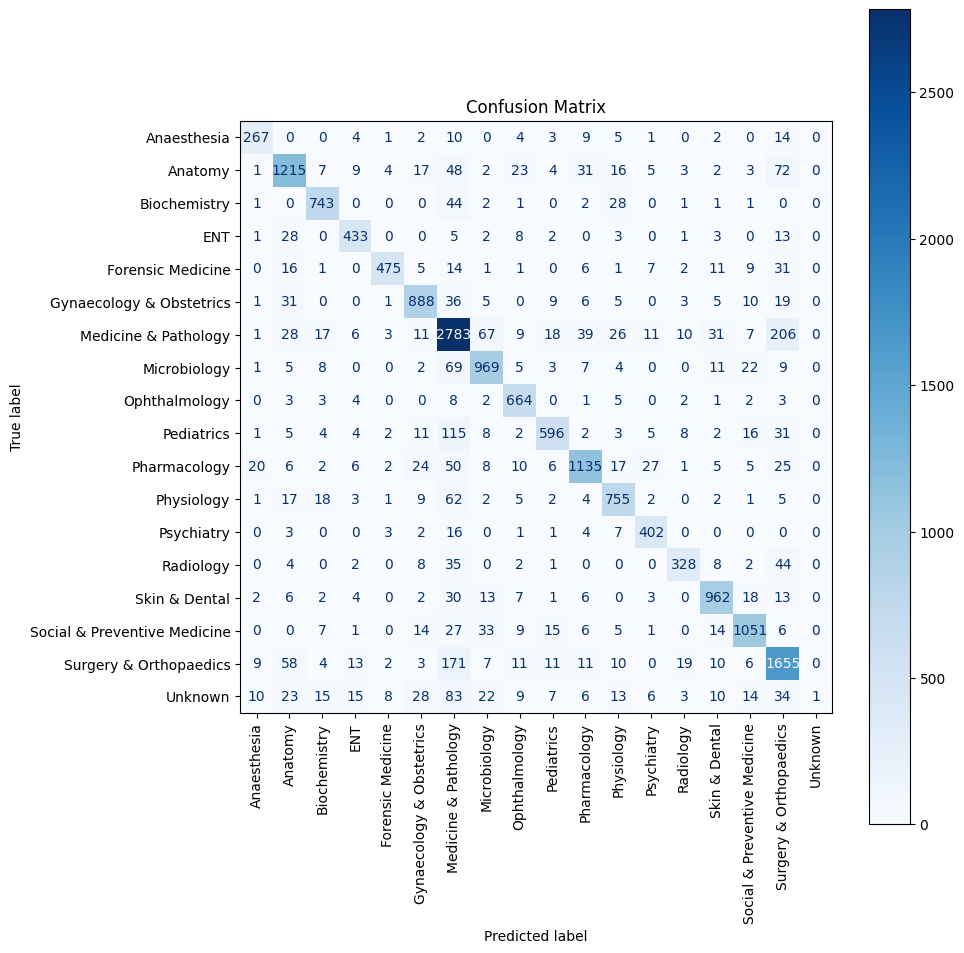

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming these are already defined
# y_true = true labels (e.g. y_test_enc)
# y_pred = predicted labels (e.g. trainer.predict(test_ds).predictions.argmax(axis=1))

cm = confusion_matrix(val_y_true, val_y_pred, labels=range(len(le.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

Analyzing the BioBert Model

In [ ]:
for name, param in bio_model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(bio_model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [ ]:
import numpy as np

def cosine_similarities(vecs, tokens=None):
    vecs = np.array(vecs)
    for i, v1 in enumerate(vecs):
        similarities = []
        for v2 in vecs:
            cos_sim = np.dot(v1, v2) / np.sqrt(np.dot(v1, v1) * np.dot(v2, v2))
            similarities.append(f"{cos_sim:.3f}")
        label = tokens[i] if tokens else f"token_{i}"
        print(f"{label}:\t" + "\t".join(similarities))

In [ ]:
from transformers import AutoModel

bio_encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


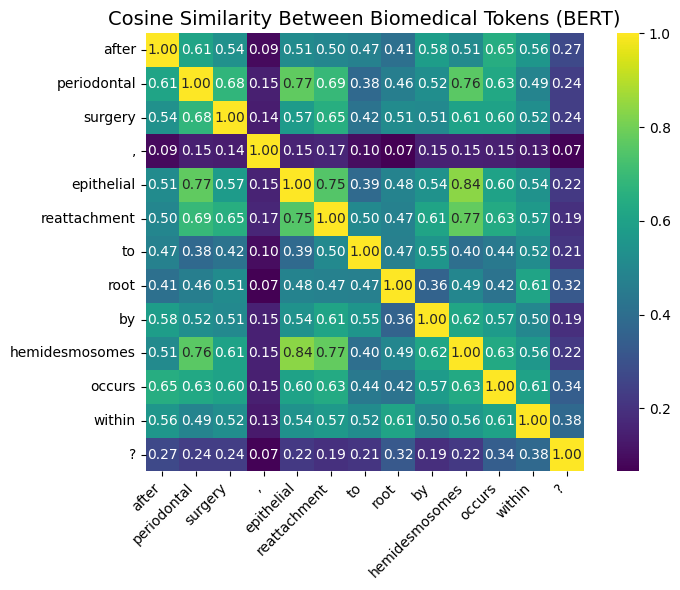

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load BioBERT encoder
model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model.eval()

# Input biomedical sentence
sentence = "After periodontal surgery, epithelial reattachment to root by hemidesmosomes occurs within?"
inputs = tokenizer(sentence, return_tensors="pt")
token_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(token_ids)

with torch.no_grad():
    outputs = model(**inputs)

# Get last hidden state
vecs = outputs.hidden_states[-1][0]  # (seq_len, hidden_dim)
vecs_np = vecs.cpu().numpy()

# Group subwords into full words
grouped_tokens = []
grouped_vecs = []

current_token = ""
current_vecs = []

for tok, vec in zip(tokens, vecs_np):
    if tok == "[CLS]" or tok == "[SEP]":
        continue
    if tok.startswith("##"):
        current_token += tok[2:]
        current_vecs.append(vec)
    else:
        if current_token:
            # Save previous word
            grouped_tokens.append(current_token)
            grouped_vecs.append(np.mean(current_vecs, axis=0))
        # Start new word
        current_token = tok
        current_vecs = [vec]

# Save last word
if current_token:
    grouped_tokens.append(current_token)
    grouped_vecs.append(np.mean(current_vecs, axis=0))

# Simple cosine similarity function
def cosine_similarities(vecs):
    vecs = np.array(vecs)
    sim_matrix = np.zeros((len(vecs), len(vecs)))
    for i, v1 in enumerate(vecs):
        for j, v2 in enumerate(vecs):
            sim_matrix[i][j] = np.dot(v1, v2) / np.sqrt(np.dot(v1, v1) * np.dot(v2, v2))
    return sim_matrix

# Print results
# print("Cosine similarities between full biomedical tokens:\n")
# cosine_similarities(grouped_vecs, grouped_tokens)

# Create similarity matrix
sim_matrix = cosine_similarities(grouped_vecs)
# Plot with labels
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix,
            xticklabels=grouped_tokens,
            yticklabels=grouped_tokens,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            square=True,
            cbar=True)

plt.title("Cosine Similarity Between Biomedical Tokens (BERT)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
cosine_similarities(vecs_selected, tokens_selected)


g:	1.000	0.719	0.682	0.769	0.686
##lut:	0.719	1.000	0.733	0.695	0.602
##ath:	0.682	0.733	1.000	0.746	0.623
##ione:	0.769	0.695	0.746	1.000	0.695
o:	0.686	0.602	0.623	0.695	1.000
